In [1]:
import os  
import numpy as np  
import random 
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data

In [3]:
train_dir = './Downloads/Training/'
test_dir = './Downloads/Testing/'

# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

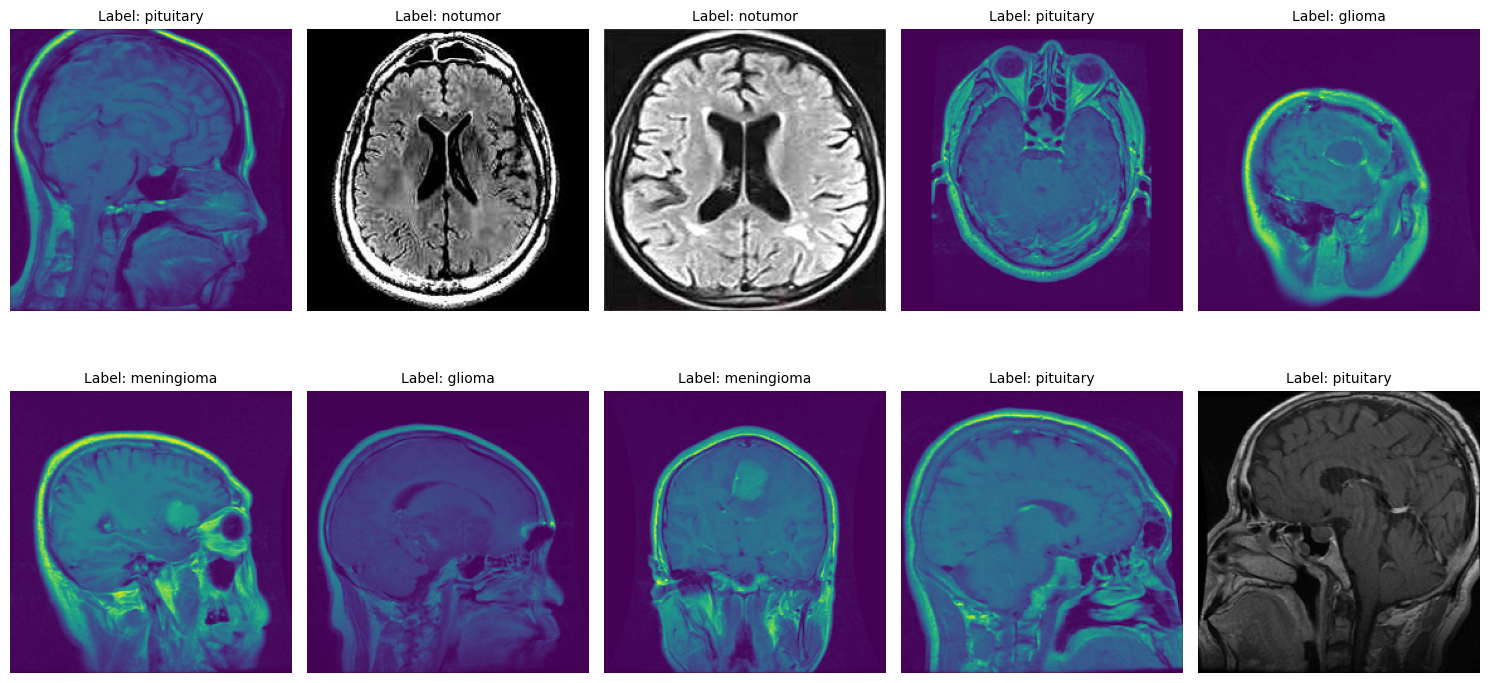

In [5]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

In [7]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
import os

IMAGE_SIZE = 64  # Reduced for speed
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

# Build model
model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(os.listdir(train_dir)), activation='softmax')
])

# Compile
model.compile(optimizer=Adam(0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Train
batch_size = 20
steps = max(10, len(train_paths) // batch_size // 5)  # Fewer steps
epochs = 25

history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)


Epoch 1/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - loss: 1.7427 - sparse_categorical_accuracy: 0.2648
Epoch 2/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - loss: 1.4284 - sparse_categorical_accuracy: 0.3102
Epoch 3/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - loss: 1.2806 - sparse_categorical_accuracy: 0.4157
Epoch 4/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - loss: 1.1788 - sparse_categorical_accuracy: 0.5006
Epoch 5/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - loss: 1.1311 - sparse_categorical_accuracy: 0.4825
Epoch 6/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - loss: 1.0612 - sparse_categorical_accuracy: 0.5773
Epoch 7/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - loss: 1.0306 - sparse_categorical_accuracy: 0.5883
Epoch 8/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - loss: 1.0182 - sparse_categorical_accuracy: 0.5663
Epoch 9/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - loss: 0.9298 - sparse_categorical_accuracy: 0.6320
Epoch 10/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - loss: 0.94

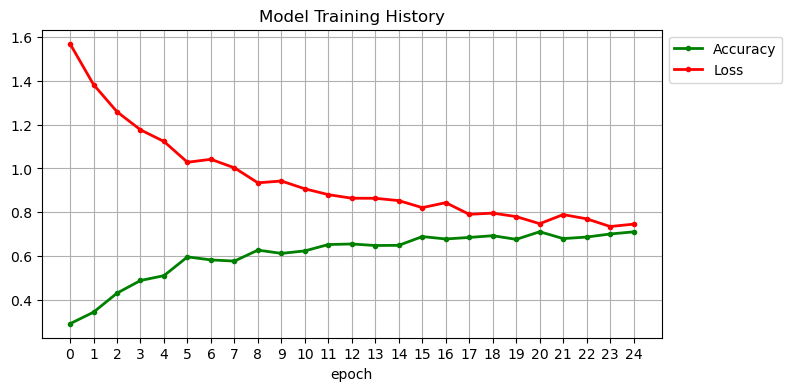

In [17]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels


test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.64      0.65       300
           1       0.55      0.48      0.51       306
           2       0.78      0.85      0.81       405
           3       0.78      0.82      0.80       300

    accuracy                           0.71      1311
   macro avg       0.69      0.70      0.69      1311
weighted avg       0.70      0.71      0.70      1311



Confusion Matrix:
[[192  84   5  19]
 [ 46 146  69  45]
 [ 41  16 343   5]
 [ 14  19  21 246]]


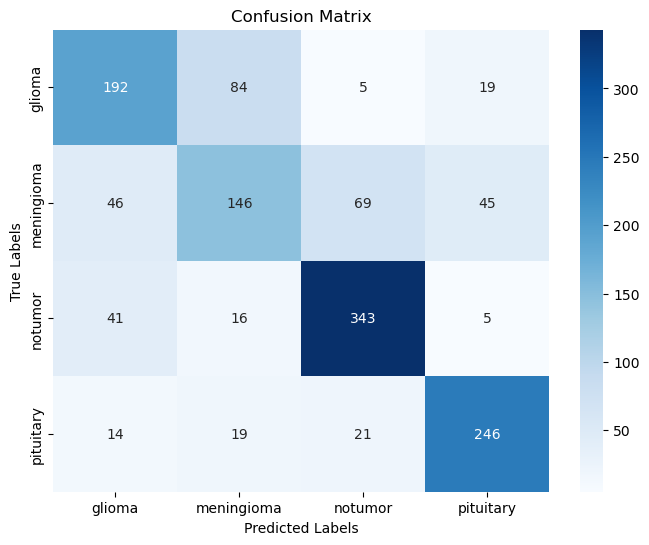

In [23]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

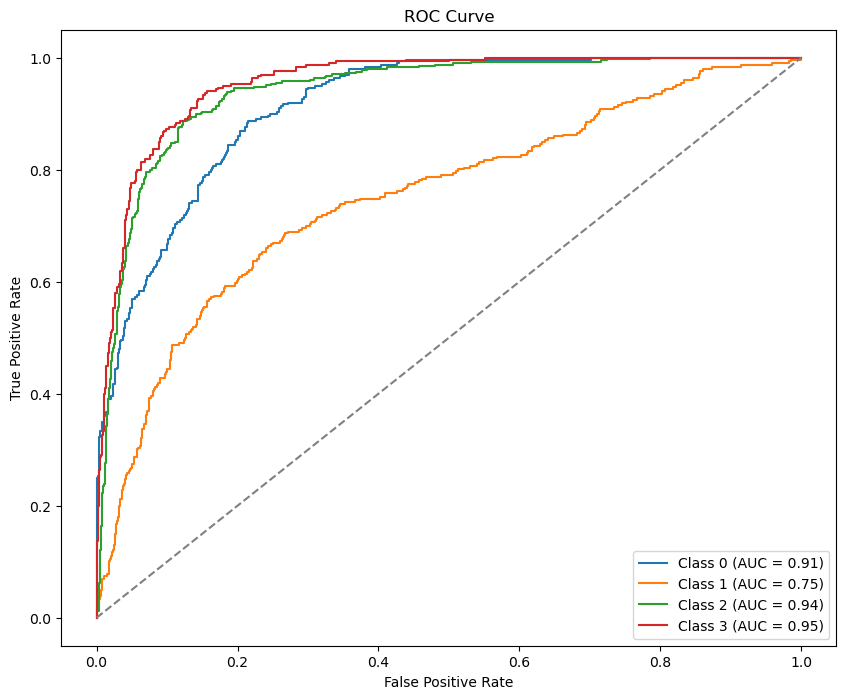

In [25]:
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [27]:
# Save the entire model
model.save('model.h5')

In [29]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

In [31]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

In [71]:
import tensorflow as tf
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])  # Match model input
    image = image / 255.0  # Normalize
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Define detection and display logic
def detect_and_display(image_tensor, model):
    try:
        predictions = model.predict(image_tensor)
        predicted_class = tf.argmax(predictions[0]).numpy()
        confidence_score = np.max(predictions, axis=1)[0]
        
        if predicted_class == 1:
            print("glioma")
        elif predicted_class == 2:
            print("meningioma")
        elif predicted_class == 3:
            print("no tumor")
        else:
            print("pituitary")
        print(confidence_score)
    except Exception as e:
        print("Error processing the image:", e)

# Path to image
image_path = './Te-meTr_0001.jpg'

# Run full flow
image_tensor = preprocess_image(image_path)
detect_and_display(image_tensor, model)




1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
meningioma
0.6292122
